In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
import random as python_random
import os

#Choose seed
my_seed = 123

# Set the python hash seed
os.environ['PYTHONHASHSEED']=str(my_seed)

# Necessary for starting Numpy generated random numbers
# in a well-defined state.
np.random.seed(my_seed)

# Necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(my_seed)

# set_seed() will make random number generation in the TensorFlow backend 
# have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(my_seed)


In [ ]:
# Install the modified keras_unet
!ls "/content/drive/My Drive/Skola/Tillämpad Bioinformatik (slutkursen)/Code/keras-unet/"

%cd "/content/drive/My Drive/Skola/Tillämpad Bioinformatik (slutkursen)/Code/keras-unet/"

!python setup.py install 

build			       model.UNet_L2_F24_S9x9_adam.h5
CHANGELOG.md		       model.UNet_L2_F24_S9x9_sgd.h5
dist			       model.UNet_L3_F12_S5x5_adam.h5
docs			       model.UNet_L3_F12_S5x5_sgd.h5
input			       model.UNet_L3_F16_S9x9_adam.h5
keras_unet		       notebooks
keras_unet.egg-info	       README.md
LICENSE			       requirements.txt
model.UNet_L1_F8_S3x3_adam.h5  setup.py
model.UNet_L1_F8_S3x3_sgd.h5   tests
/content/drive/.shortcut-targets-by-id/1k2fyapEMr2C8S-A4cmxr0DRCgmBtJk5G/Tillämpad Bioinformatik (slutkursen)/Code/keras-unet
running install
running bdist_egg
running egg_info
writing keras_unet.egg-info/PKG-INFO
writing dependency_links to keras_unet.egg-info/dependency_links.txt
writing top-level names to keras_unet.egg-info/top_level.txt
reading manifest file 'keras_unet.egg-info/SOURCES.txt'
writing manifest file 'keras_unet.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
crea

In [ ]:
#import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import os
import sys
from PIL import Image
#import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from keras_unet.utils import plot_imgs
from sklearn.model_selection import train_test_split
from keras_unet.models import custom_unet
from keras.callbacks import ModelCheckpoint
from keras_unet.metrics import iou, iou_thresholded
from keras.optimizers import Adam, SGD
from keras_unet.utils import get_augmented
from keras_unet.utils import plot_segm_history
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
import csv
import time
from matplotlib.pyplot import cm
from cycler import cycler

%cd "/content/"

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------
/content


In [ ]:
train_images = sorted(glob.glob("/content/drive/My Drive/UNet/TrainingImages/*.tif"))
train_masks = sorted(glob.glob("/content/drive/My Drive/UNet/TrainingLabels/*.tif"))

test_images = sorted(glob.glob("/content/drive/My Drive/UNet/IndependentTestImages/*.tif"))
test_masks = sorted(glob.glob("/content/drive/My Drive/UNet/IndependentTestLabels/*.tif"))

In [ ]:
def prepare_images_masks(images, masks):
    
    I_list = []
    M_list = []
    for image, mask in zip(images, masks):
        I = Image.open(image)
        M = Image.open(mask)

        I = np.array(I)
        M = np.array(M)

        I_list.append(I/(I.max()))
        M_list.append(M/(M.max()))

    X = np.asarray(I_list, dtype=np.float32)
    Y = np.asarray(M_list, dtype=np.float32)

    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1) 
    Y = Y.reshape(Y.shape[0], Y.shape[1], Y.shape[2], 1)
    
    return X, Y


X, Y = prepare_images_masks(train_images, train_masks)
X_test, Y_test = prepare_images_masks(test_images, test_masks)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, train_size=0.75, random_state=33)

print("# X_train: %d" % X_train.shape[0])
print("# Y_train: %d" % Y_train.shape[0])
print("# X_val: %d" % X_val.shape[0])
print("# Y_val: %d" % Y_val.shape[0])

# X_train: 6
# Y_train: 6
# X_val: 2
# Y_val: 2


In [ ]:
train_gen = get_augmented(
    X_train, Y_train, batch_size=2, seed=my_seed,
    data_gen_args = dict(
        rotation_range=360.0,
        fill_mode='constant')
)

In [ ]:
# Parameters

# Currently set to test netowrks with a kernel size of 9x9
layers = [1,2,3,4]
filters = [8,12,16,24,32]
#kernel_sizes = [3,5,7,9]
kernel_sizes = [9]

filename = "kernel_9x9"

In [ ]:
# Creates new keras session with the defined seed. Could probably be skipped
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

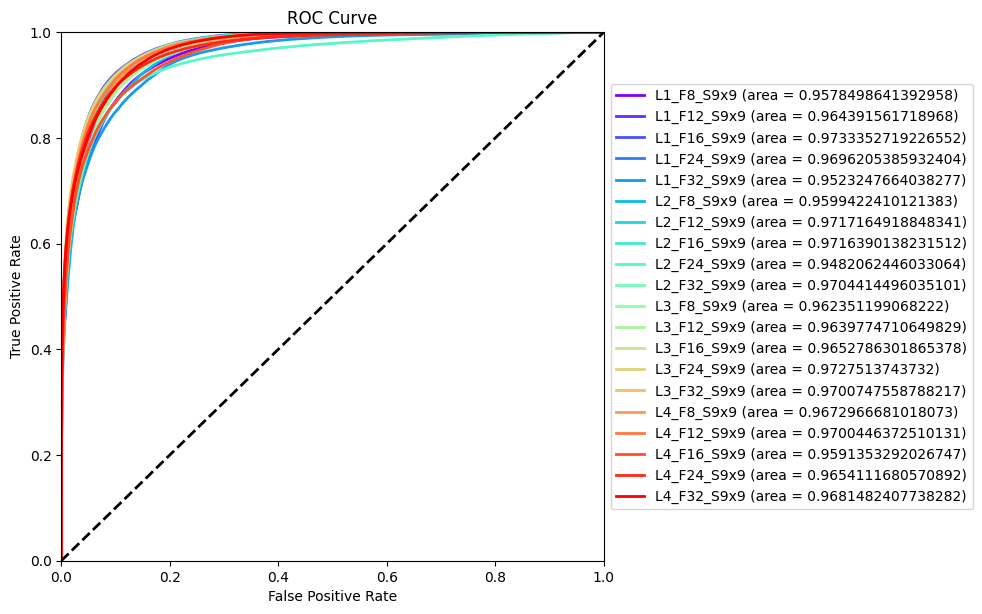

In [ ]:
input_shape = X_train[0].shape

# Initialize arrays for saving data: shape, time elapsed, auc, fpr, tpr, number of parameters
shapes = []
time_elapsed = []
auc_list = []
fpr_list = []
tpr_list = []
nr_param = []

# For larger plot
plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

plt.figure()
lw = 2

# Initialize color cycle
n_lines = len(layers)*len(filters)*len(kernel_sizes)
colors=cm.rainbow(np.linspace(0,1,n_lines))

plt.rc('axes', prop_cycle=(cycler('color', colors)))

# Parse through each combination of parameters
for layer in layers:
  for filter in filters:
    for kernel in kernel_sizes:
      

      # Define net architecture
      model = custom_unet(
        input_shape,
        filters=filter,
        kernel_size=(kernel, kernel), 
        num_layers=layer
      )

      # Define file name
      model_filename = f'UNet_L{layer}_F{filter}_S{kernel}x{kernel}.h5'
      

      my_callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=25),
        tf.keras.callbacks.ModelCheckpoint(filepath='model.' + model_filename,
                                          verbose=0, 
                                          monitor='val_loss', 
                                          save_best_only=True)
      ]

      model.compile(
        optimizer=Adam(), 
        #optimizer=SGD(lr=0.0001, momentum=0.9),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.BinaryAccuracy()]
      )

      # Measure the time
      start_time = time.time()
      
      history = model.fit(
        train_gen,
        steps_per_epoch=10,
        epochs=500,
        validation_data=(X_val, Y_val),
        callbacks=[my_callbacks],
        verbose=0
      )

      end_time = time.time()
      elapsed_time = (end_time - start_time)/60

      # Uncomment to saved trained models to Google Drive 
      #model.save(F"/content/drive/My Drive/Skola/Tillämpad Bioinformatik (slutkursen)/Unet-output/{model_filename}")

      # Predition
      Y_pred = model.predict(X_test)

      N_Y_pred = Y_pred.shape[0]
      Y_score = np.empty(())
      Y_true = np.array(())

      for i in range(N_Y_pred):
          I_score = Y_pred[i, :, :, :]
          I_score = I_score.flatten()
          
          I_true = Y_test[i, :, :, :]
          I_true = I_true.flatten()
          I_true_b = label_binarize(I_true, classes=[0, 1])
          
          if i == 0:
              Y_score = I_score
              Y_true = I_true_b
          else:
              Y_score = np.concatenate((Y_score, I_score), axis = 0)
              Y_true = np.concatenate((Y_true, I_true_b), axis = 0)
          
      # Calculate false and true positive rate as well as the AUC       
      fpr, tpr, _ = roc_curve(y_true=Y_true, y_score=Y_score)
      roc_auc = auc(fpr, tpr)

      # Add values to the arrays
      shapes.append(f'L{layer}_F{filter}_S{kernel}x{kernel}')
      time_elapsed.append(elapsed_time)
      auc_list.append(roc_auc)
      nr_param.append(model.count_params())

      # Plot performance
      plt.plot(fpr, tpr, lw=lw, label=f'L{layer}_F{filter}_S{kernel}x{kernel} (area = {roc_auc})')
      
# Save results to csv-file
with open(f"/content/drive/My Drive/Skola/Tillämpad Bioinformatik (slutkursen)/Unet-output/{filename}.csv", 'w', newline='') as myfile:
  wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
  for i in range(len(layers)*len(filters)*len(kernel_sizes)):
    wr.writerow([shapes[i], time_elapsed[i], auc_list[i], nr_param[i]])

# Plot the performance of the tested networks
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
plt.savefig(f'/content/drive/My Drive/Skola/Tillämpad Bioinformatik (slutkursen)/Unet-output/{filename}.png', bbox_inches='tight')